In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MultiLabelBinarizer

# Load Data from Clarify

In [2]:
input_path = 'Input/'

t_line_drug= input_path + 'patient_oncologicalTreatmentLine_drugs.csv'
d_no_onco = input_path + 'patient_nonOncologycalTreatments.csv'

treatment_line_drug = pd.read_csv(t_line_drug, delimiter=",")
drug_no_onco = pd.read_csv(d_no_onco, delimiter=",")

# Load Data from BigMedialytis

In [2]:
input_path = '../../data/BigMedialytis/BM_v04/lc_notes/'

t_line_drug= input_path + 'patient_oncologicalTreatmentLine_drugs.csv'
d_no_onco = input_path + 'patient_nonOncologycalTreatments.csv'

treatment_line_drug = pd.read_csv(t_line_drug, delimiter=",")
drug_no_onco = pd.read_csv(d_no_onco, delimiter=",")

# Preprocessing non-oncological drugs

In [3]:
#treatment_line_drug['drug_name'] = treatment_line_drug['drug_name'].str.lower()
#drug_no_onco['drug_name'] = drug_no_onco['drug_name'].str.lower()

replacement_mapping_dict = {
    'Enalaprile': 'Enalapril',
    'Atenolole': 'Atenolol',
    'Azitromicina': 'Azithromycin',
    'Immunoglobulin_g': 'Human_immunoglobulin_g',
}
drug_no_onco['drug_name'].replace(replacement_mapping_dict, inplace=True)
drug_no_onco = drug_no_onco.loc[~drug_no_onco.drug_name.isin(['Antibiotic','Analgesic','Antibiotics','Insulin','Corticoids'])]

display(treatment_line_drug.shape, treatment_line_drug.head())
display(drug_no_onco.shape, drug_no_onco.head())

(2012, 3)

,patient_id,oncologicalTreatmentLine_id,drug_name
0,1003706,693,Cisplatin
1,1003706,693,Docetaxel
2,1003706,693,Pemetrexed
3,1007602,694,Carboplatin
4,1007602,694,Etoposide


(1290, 2)

,patient_id,drug_name
0,1098173,Omeprazole
1,1098173,Ranitidine
2,1100890,Omeprazole
3,1103334,Omeprazole
4,1103334,Enalapril


# Select drugs by each line

In [4]:
cancer_treatment = pd.merge(treatment_line_drug[['patient_id', 'oncologicalTreatmentLine_id']], drug_no_onco, how='inner',
                          on=['patient_id'])
cancer_treatment.drop_duplicates(keep='first', inplace=True)
cancer_treatment = pd.concat([cancer_treatment, treatment_line_drug])

cancer_treatment = cancer_treatment.sort_values(by=['oncologicalTreatmentLine_id'])
cancer_treatment

,patient_id,oncologicalTreatmentLine_id,drug_name
1559,3877,2,Atenolol
1259,3877,2,Etoposide
1258,3877,2,Carboplatin
1558,3877,2,Omeprazole
2018,6203,3,Omeprazole
...,...,...,...
1365,2812085,1289,Simvastatin
1138,2815387,1290,Cisplatin
1366,2815387,1290,Omeprazole
1139,2815387,1291,Pembrolizumab


In [5]:
df_drug = cancer_treatment.groupby(by=['patient_id','oncologicalTreatmentLine_id']).agg(lambda x: x.tolist()).reset_index()
df_drug

,patient_id,oncologicalTreatmentLine_id,drug_name
0,3877,2,"[Atenolol, Etoposide, Carboplatin, Omeprazole]"
1,6203,3,"[Omeprazole, Cisplatin, Pemetrexed, Vinorelbine]"
2,6203,4,"[Omeprazole, Crizotinib, Erlotinib]"
3,12870,7,"[Atorvastatin, Carboplatin, Vinorelbine]"
4,17581,8,"[Vinorelbine, Omeprazole, Cisplatin]"
...,...,...,...
1258,2811447,1287,"[Omeprazole, Nivolumab, Atorvastatin]"
1259,2812085,1288,"[Pemetrexed, Simvastatin]"
1260,2812085,1289,"[Nivolumab, Simvastatin]"
1261,2815387,1290,"[Cisplatin, Omeprazole]"


In [6]:
onco_drug = set(treatment_line_drug.drug_name.unique())
set_drugs = set()
for i in range(df_drug.shape[0]):
    # == write the number of drug of the treatment
    drugs = df_drug.drug_name[i]
    drugs.sort()    
    df_drug.at[i,'n_drugs'] = len(drugs)
    #df_drug.at[i,'drug_name']=drugs
    
    # == write the number of oncological drugs of the treatment
    set_d = list(set.intersection(onco_drug, set(drugs)))
    set_d.sort()    
    df_drug.at[i,'n_drug_onco'] = len(set_d)
    #df_drug.at[i,'oncological_drug'] = ', '.join(list(set_d))
    
    # == write the treatment order by onco_drug + non-onco_drug
    non_onco_drug = list(set(drugs) - set(set_d))
    non_onco_drug.sort()
    df_drug.at[i,'treatment'] = ', '.join(set_d + non_onco_drug)
    set_drugs.update(set(set_d + non_onco_drug))
    
df_drug['n_drugs'] = df_drug['n_drugs'].astype(int)
df_drug['n_drug_onco'] = df_drug['n_drug_onco'].astype(int)
df_drug = df_drug.loc[df_drug['n_drugs']>4]
df_drug = df_drug.sort_values(by=['n_drug_onco', 'n_drugs'], ascending=False)
df_drug

,patient_id,oncologicalTreatmentLine_id,drug_name,n_drugs,n_drug_onco,treatment
677,1015121,698,"[Cisplatin, Docetaxel, Gemcitabine, Metformin,...",7,5,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,..."
407,621354,418,"[Allopurinol, Amlodipine, Atenolol, Carboplati...",8,4,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin..."
220,348648,228,"[Allopurinol, Cisplatin, Enalapril, Gemcitabin...",7,4,"Cisplatin, Gemcitabine, Paclitaxel, Vinorelbin..."
423,638929,434,"[Acetaminophen, Carboplatin, Docetaxel, Gemcit...",6,4,"Carboplatin, Docetaxel, Gemcitabine, Pemetrexe..."
478,669022,489,"[Acetaminophen, Carboplatin, Docetaxel, Omepra...",6,4,"Carboplatin, Docetaxel, Paclitaxel, Vinorelbin..."
...,...,...,...,...,...,...
814,1166878,839,"[Dexamethasone, Levofloxacin, Omeprazole, Pemb...",5,1,"Pembrolizumab, Dexamethasone, Levofloxacin, Om..."
961,2336932,989,"[Acetaminophen, Afatinib, Ibuprofen, Omeprazol...",5,1,"Afatinib, Acetaminophen, Ibuprofen, Omeprazole..."
995,2378188,1023,"[Acetaminophen, Afatinib, Amlodipine, Lorazepa...",5,1,"Afatinib, Acetaminophen, Amlodipine, Lorazepam..."
996,2378188,1024,"[Acetaminophen, Amlodipine, Erlotinib, Lorazep...",5,1,"Erlotinib, Acetaminophen, Amlodipine, Lorazepa..."


In [7]:
treatment = df_drug[['treatment', 'n_drugs']]
treatment.drop_duplicates(keep='first', inplace=True)



replacement_mapping_dict = {
    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Enalapril, Lorazepam, Metformin, Omeprazole': 
    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Lorazepam, Metformin, Omeprazole',
    'Carboplatin, Etoposide, Amlodipine, Atenolol, Enalapril, Omeprazole, Prednisone':
    'Carboplatin, Etoposide, Amlodipine, Atenolol, Omeprazole, Prednisone',
    'Carboplatin, Gemcitabine, Atenolol, Atorvastatin, Enalapril, Omeprazole, Simvastatin':
    'Carboplatin, Gemcitabine, Atenolol, Atorvastatin, Omeprazole, Simvastatin',
    'Ipilimumab, Nivolumab, Atenolol, Atorvastatin, Enalapril, Omeprazole, Simvastatin':
    'Ipilimumab, Nivolumab, Atenolol, Atorvastatin, Omeprazole, Simvastatin',
    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Enalapril, Omeprazole':
    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Omeprazole',
    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Omeprazole, Ranitidine':
    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Ranitidine',
    'Carboplatin, Vinorelbine, Atenolol, Atorvastatin, Enalapril, Omeprazole':
    'Carboplatin, Vinorelbine, Atenolol, Atorvastatin, Omeprazole',
    'Carboplatin, Amlodipine, Atenolol, Atorvastatin, Enalapril, Metformin, Omeprazole':
    'Carboplatin, Amlodipine, Atenolol, Atorvastatin, Metformin, Omeprazole',
    'Nivolumab, Acetaminophen, Amlodipine, Atorvastatin, Enalapril, Omeprazole, Simvastatin':
    'Nivolumab, Acetaminophen, Amlodipine, Enalapril, Omeprazole, Simvastatin',
    'Carboplatin, Atorvastatin, Enalapril, Metformin, Omeprazole, Simvastatin':
    'Carboplatin, Atorvastatin, Enalapril, Metformin, Omeprazole',
    'Nivolumab, Atorvastatin, Enalapril, Metformin, Omeprazole, Simvastatin':
    'Nivolumab, Atorvastatin, Enalapril, Metformin, Omeprazole',
    'Carboplatin, Amlodipine, Atenolol, Atorvastatin, Enalapril, Omeprazole':
    'Carboplatin, Amlodipine, Atenolol, Atorvastatin, Omeprazole',
    'Carboplatin, Atenolol, Atorvastatin, Enalapril, Metformin, Omeprazole':
    'Carboplatin, Atenolol, Atorvastatin, Metformin, Omeprazole',
    'Docetaxel, Atenolol, Atorvastatin, Enalapril, Metformin, Omeprazole':
    'Docetaxel, Atenolol, Atorvastatin, Metformin, Omeprazole',
}

remove_treatment = ['Carboplatin, Etoposide, Atenolol, Enalapril, Omeprazole', 
                    'Carboplatin, Pemetrexed, Atenolol, Enalapril, Omeprazole', 
                    'Carboplatin, Paclitaxel, Omeprazole, Ranitidine, Simvastatin',
                    'Carboplatin, Etoposide, Atorvastatin, Omeprazole, Simvastatin',
                    'Carboplatin, Pemetrexed, Atorvastatin, Omeprazole, Simvastatin',
                    'Cisplatin, Pemetrexed, Atorvastatin, Omeprazole, Simvastatin',
                    'Carboplatin, Etoposide, Atenolol, Atorvastatin, Simvastatin',
                    'Vinorelbine, Atenolol, Enalapril, Metformin, Simvastatin',
                    'Carboplatin, Atenolol, Enalapril, Metformin, Simvastatin',
                    'Paclitaxel, Atenolol, Enalapril, Metformin, Simvastatin',
                    'Nivolumab, Atenolol, Enalapril, Metformin, Simvastatin',
                    'Nivolumab, Atenolol, Atorvastatin, Enalapril, Omeprazole, Simvastatin',                    
                   ]
treatment = treatment.loc[~treatment.treatment.isin(remove_treatment)]
treatment['treatment'].replace(replacement_mapping_dict, inplace=True)
#treatment = treatment.loc[treatment.astype(str).drop_duplicates().index].reset_index()
#treatment = treatment.drop(columns=['index'])
treatment

/home/rivas/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,treatment,n_drugs
677,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,...",7
407,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin...",8
220,"Cisplatin, Gemcitabine, Paclitaxel, Vinorelbin...",7
423,"Carboplatin, Docetaxel, Gemcitabine, Pemetrexe...",6
478,"Carboplatin, Docetaxel, Paclitaxel, Vinorelbin...",6
...,...,...
814,"Pembrolizumab, Dexamethasone, Levofloxacin, Om...",5
961,"Afatinib, Acetaminophen, Ibuprofen, Omeprazole...",5
995,"Afatinib, Acetaminophen, Amlodipine, Lorazepam...",5
996,"Erlotinib, Acetaminophen, Amlodipine, Lorazepa...",5


In [8]:
treatment[['treatment']].to_csv('treatments/cancer_treatments.csv', index=False)

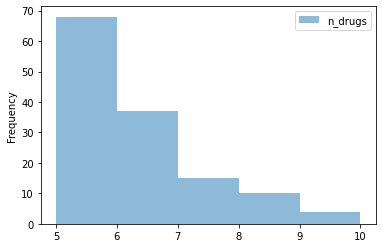

In [8]:
df = treatment[['n_drugs']]
ax = df.plot.hist(bins=5, alpha=0.5)

In [8]:
set_drugs

{'Acetaminophen',
 'Afatinib',
 'Alectinib',
 'Allopurinol',
 'Amlodipine',
 'Amoxicillin',
 'Atenolol',
 'Atorvastatin',
 'Azithromycin',
 'Bevacizumab',
 'Carboplatin',
 'Ceftriaxone',
 'Ceritinib',
 'Ciprofloxacin',
 'Cisplatin',
 'Crizotinib',
 'Dexamethasone',
 'Dexketoprofen',
 'Docetaxel',
 'Enalapril',
 'Enoxaparin',
 'Erlotinib',
 'Etoposide',
 'Fentanyl',
 'Furosemide',
 'Gefitinib',
 'Gemcitabine',
 'Gentamicin',
 'Human_immunoglobulin_g',
 'Ibuprofen',
 'Ipilimumab',
 'Levofloxacin',
 'Lorazepam',
 'Lormetazepam',
 'Metformin',
 'Methylprednisolone',
 'Metoclopramide',
 'Necitumumab',
 'Nivolumab',
 'Omeprazole',
 'Ondansetron',
 'Osimertinib',
 'Paclitaxel',
 'Pembrolizumab',
 'Pemetrexed',
 'Prednisone',
 'Ranitidine',
 'Salbutamol',
 'Simvastatin',
 'Spironolactone',
 'Sulfamethoxazole',
 'Tramadol',
 'Trimethoprim',
 'Vinorelbine'}

In [9]:
#drugBank_id_name = pd.read_csv('../store_data/drug/drugBank_id_name.csv', delimiter=",")
drugBank_id_name = pd.read_csv('../../data/Clarify/v6.2/drug/drugBank_id_name.csv', delimiter=",")
display(drugBank_id_name.shape, drugBank_id_name.head())

(14315, 2)

,DrugBankID,DrugName
0,DB00001,Lepirudin
1,DB00002,Cetuximab
2,DB00003,Dornase_alfa
3,DB00004,Denileukin_diftitox
4,DB00005,Etanercept


In [11]:
len(set_drugs)

54

In [12]:
drug_treatment = pd.DataFrame(set_drugs, columns=['DrugName'])
drug_id = pd.merge(drugBank_id_name,drug_treatment,on='DrugName')
drug_id.to_csv('treatments/KG_drugBank_id.csv', index=False)
drug_id

,DrugBankID,DrugName
0,DB00028,Human_immunoglobulin_g
1,DB00112,Bevacizumab
2,DB00186,Lorazepam
3,DB00193,Tramadol
4,DB00207,Azithromycin
5,DB00316,Acetaminophen
6,DB00317,Gefitinib
7,DB00331,Metformin
8,DB00335,Atenolol
9,DB00338,Omeprazole


In [9]:
df_drug = df_drug.loc[~df_drug.treatment.isin(remove_treatment)]
df_drug['treatment'].replace(replacement_mapping_dict, inplace=True)
df_drug

/home/rivas/.local/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,patient_id,oncologicalTreatmentLine_id,drug_name,n_drugs,n_drug_onco,treatment
677,1015121,698,"[Cisplatin, Docetaxel, Gemcitabine, Metformin,...",7,5,"Cisplatin, Docetaxel, Gemcitabine, Pemetrexed,..."
407,621354,418,"[Allopurinol, Amlodipine, Atenolol, Carboplati...",8,4,"Carboplatin, Docetaxel, Pemetrexed, Vinorelbin..."
220,348648,228,"[Allopurinol, Cisplatin, Enalapril, Gemcitabin...",7,4,"Cisplatin, Gemcitabine, Paclitaxel, Vinorelbin..."
423,638929,434,"[Acetaminophen, Carboplatin, Docetaxel, Gemcit...",6,4,"Carboplatin, Docetaxel, Gemcitabine, Pemetrexe..."
478,669022,489,"[Acetaminophen, Carboplatin, Docetaxel, Omepra...",6,4,"Carboplatin, Docetaxel, Paclitaxel, Vinorelbin..."
...,...,...,...,...,...,...
814,1166878,839,"[Dexamethasone, Levofloxacin, Omeprazole, Pemb...",5,1,"Pembrolizumab, Dexamethasone, Levofloxacin, Om..."
961,2336932,989,"[Acetaminophen, Afatinib, Ibuprofen, Omeprazol...",5,1,"Afatinib, Acetaminophen, Ibuprofen, Omeprazole..."
995,2378188,1023,"[Acetaminophen, Afatinib, Amlodipine, Lorazepa...",5,1,"Afatinib, Acetaminophen, Amlodipine, Lorazepam..."
996,2378188,1024,"[Acetaminophen, Amlodipine, Erlotinib, Lorazep...",5,1,"Erlotinib, Acetaminophen, Amlodipine, Lorazepa..."


In [17]:
df_drug.treatment.value_counts()[:10]

Cisplatin, Vinorelbine, Enalapril, Omeprazole, Simvastatin                2
Cisplatin, Vinorelbine, Atenolol, Omeprazole, Simvastatin                 2
Carboplatin, Paclitaxel, Atorvastatin, Enalapril, Omeprazole              2
Carboplatin, Etoposide, Atenolol, Atorvastatin, Omeprazole                2
Carboplatin, Paclitaxel, Atenolol, Omeprazole, Simvastatin                2
Carboplatin, Etoposide, Atorvastatin, Enalapril, Metformin, Omeprazole    2
Carboplatin, Etoposide, Furosemide, Metformin, Omeprazole                 2
Cisplatin, Pemetrexed, Enalapril, Lorazepam, Omeprazole                   1
Carboplatin, Etoposide, Amlodipine, Atorvastatin, Metformin               1
Alectinib, Crizotinib, Atorvastatin, Enalapril, Omeprazole                1
Name: treatment, dtype: int64

In [16]:
df_drug[['patient_id', 'oncologicalTreatmentLine_id', 'treatment']].to_csv('treatments/BM_treatment.csv', index=False)